# Importing

Importing the necessary libraries

In [52]:
import os
import pandas as pd
import numpy as np

import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Data Processing

In [53]:
directory = "/Users/vbraun/Downloads/training_set/"

Code to append movieId to each record in all of the source files if this has not been executed earlier. This will allow all the source files to be loaded into a dataframe with one line of code and without having to add the movieId seperately before concatting the sourcefiles.

In [54]:
def movieId_to_source():
    x = 0
    string = ","+str(x)
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r') as f:
            if(f.readlines()[0] == '1:,1\n'):
                print('Already formatted, continuing')
                return
            else:
                file_lines = [''.join([x.strip(), string, '\n']) for x in f.readlines()]
        with open(os.path.join(directory, filename), 'w') as f:
            f.writelines(file_lines)
    return

In [55]:
movieId_to_source()

Already formatted, continuing


Creating the movie dataframe by concatting all the sourcefiles without their title (skiprows=1). Concluding with naming the columns.

In [56]:
movie_df = pd.concat(pd.read_csv(os.path.join(directory, fname), skiprows=1,header=None) for fname in os.listdir(directory)).rename(columns={0:'userId',1:'rating',2:'date',3:'itemId'})

display(movie_df.head(5))

,userId,rating,date,itemId
0,1488844,3,2005-09-06,1
1,822109,5,2005-05-13,1
2,885013,4,2005-10-19,1
3,30878,4,2005-12-26,1
4,823519,3,2004-05-03,1


Dropping the date column as this is not relevant for this RecSys

In [57]:
movie_df = movie_df.drop(columns='date')

### Data filtering

To allow for faster development a debugging variable is used. If debugging is True the dataset will only consist of the first 100 movies. For the final model, debugging will be set to False.

In [58]:
debugging = False

In [59]:
if debugging == True:
    filtered_movie_df = movie_df[movie_df['itemId'] <= 100]
else:
    filtered_movie_df = movie_df
print('Length of dataset:',len(filtered_movie_df))

Length of dataset: 100480507


In order to filter the dataset based on activity and reduce the sparsity of the data, the data will be grouped and filtered based on movies and users. The datasets will show how many ratings each movie has gotten and how many rating each user has given.

In [60]:
filtered_movie_count = filtered_movie_df[['itemId','userId']].groupby('itemId').count().reset_index().rename(columns={'userId':'user_count'})
filtered_user_count = filtered_movie_df[['itemId','userId']].groupby('userId').count().reset_index().rename(columns={'itemId':'item_count'})

display(filtered_movie_count.head(3),filtered_user_count.head(3))

,itemId,user_count
0,1,547
1,2,145
2,3,2012


,userId,item_count
0,6,626
1,7,881
2,8,98


To reduce the sparcity of data in the dataset, we will filter out the users that have rated fewer than 5% of the total amount of movies.

In [61]:
filtered_movie_df = filtered_movie_df[filtered_movie_df['userId'].isin(filtered_user_count[filtered_user_count['item_count']/len(filtered_movie_count) > 0.05]['userId'])]

print('Length of dataset:',len(filtered_movie_df))

Length of dataset: 23116049


Finally, the movies that have been rated by fewer than 50 people will be filtered out of the dataset.

In [62]:
filtered_movie_df = filtered_movie_df[filtered_movie_df['itemId'].isin(filtered_movie_count[filtered_movie_count['user_count']>50]['itemId'])]

print('Length of dataset:',len(filtered_movie_df))

Length of dataset: 23115305


# EDA

In [63]:
print('The filtered dataset has', filtered_movie_df['userId'].nunique(), 'unique users')
print('The filtered dataset has', filtered_movie_df['itemId'].nunique(), 'unique movies')
print('The filtered dataset has', filtered_movie_df['rating'].nunique(), 'unique ratings')
print('The unique ratings are', sorted(filtered_movie_df['rating'].unique()))

The filtered dataset has 17740 unique users
The filtered dataset has 17711 unique movies
The filtered dataset has 5 unique ratings
The unique ratings are [1, 2, 3, 4, 5]


In [64]:
display(filtered_movie_df.head(),filtered_movie_df.tail())

,userId,rating,itemId
0,1488844,3,1
3,30878,4,1
7,1248029,3,1
19,372233,5,1
20,1080361,3,1


,userId,rating,itemId
915,311124,3,17770
916,1790158,4,17770
918,234275,1,17770
919,255278,4,17770
920,453585,2,17770


In [65]:
filtered_movie_df.describe()

,userId,rating,itemId
count,2.311530e+07,2.311530e+07,2.311530e+07
mean,1.330438e+06,3.440626e+00,8.985787e+03
std,7.630050e+05,1.090647e+00,5.113650e+03
min,7.690000e+02,1.000000e+00,1.000000e+00
25%,6.749270e+05,3.000000e+00,4.640000e+03
50%,1.326360e+06,3.000000e+00,8.928000e+03
75%,1.995910e+06,4.000000e+00,1.348600e+04
max,2.649285e+06,5.000000e+00,1.777000e+04


In [66]:
print('Amount of NaN values in the dataset:',filtered_movie_df.loc[lambda x: x.isnull().any(axis=1)].shape[0])

Amount of NaN values in the dataset: 0


The following graph shows for each movie (as a dot) what its mean rating is in comparison to the total amount of ratings. 

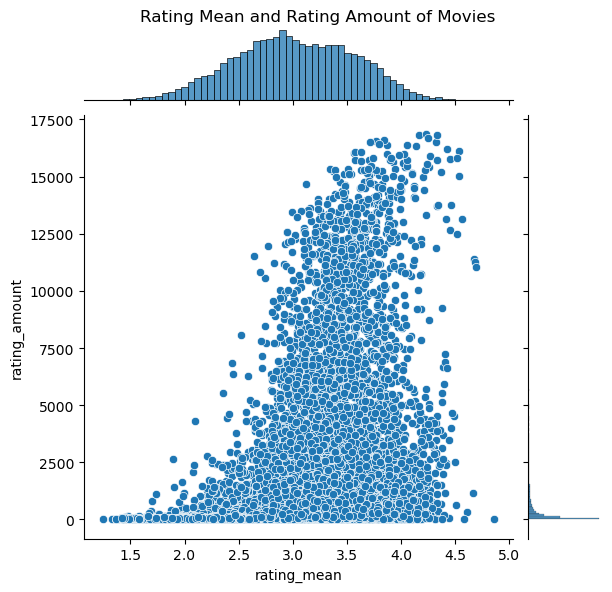

In [67]:
plt = sns.jointplot(x='rating_mean', y='rating_amount', data=filtered_movie_df.groupby('itemId').agg(rating_mean = ('rating', 'mean'), rating_amount = ('rating', 'count')).reset_index())
plt.fig.suptitle("Rating Mean and Rating Amount of Movies")
plt.fig.subplots_adjust(top=0.95)

Notably, movies with low mean ratings have generally been rated a low number of times in relation to movies with a mean rating higher than 3.0.

The next graph shows the same variables as the graph seen above for each user. 

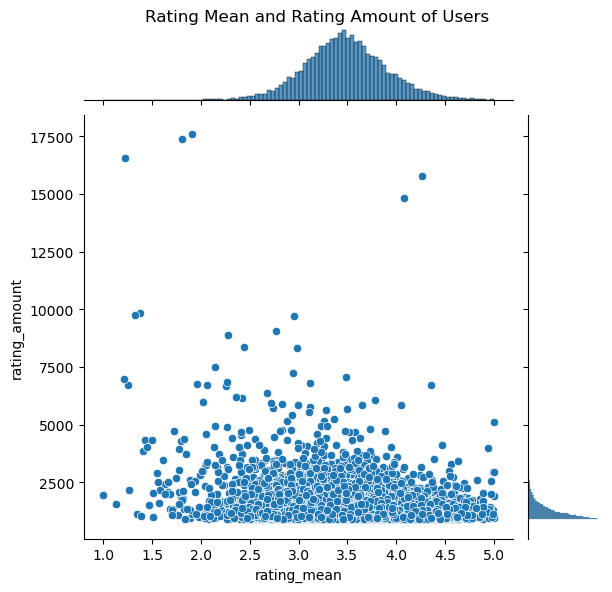

In [68]:
plt = sns.jointplot(x='rating_mean', y='rating_amount', data=filtered_movie_df.groupby('userId').agg(rating_mean = ('rating', 'mean'), rating_amount = ('rating', 'count')).reset_index())
plt.fig.suptitle("Rating Mean and Rating Amount of Users")
plt.fig.subplots_adjust(top=0.95)

The graph for users show that there are several outliers of users that have rated many movies while having a low mean of their ratings. Their tendency to rate movies lower in general may have an influence on the mean ratings of those movies. Therefore, in order to reduce this impact the mean rating of a user will subtracted from each rating they have given. This will ensure that the rating shows the positive or negative difference from their base.

# Singular Value Decomposition

Pivot the dataset into a matrix with index='userId', columns='itemId', values='rating' in order to later perform user-based collaborative filtering. Moreover, fill_value = 0 in order to remove NaN values and save them as 0. Finally, the matrix is directly stored as a sparse matrix to save memory, instead of first saving the entire matrix into memory. 

In [69]:
sparse_matrix = csr_matrix(filtered_movie_df.pivot_table(index='userId', columns='itemId', values='rating').subtract(filtered_movie_df.pivot_table(index='userId', columns='itemId', values='rating').mean(axis=1), axis = 'rows').fillna(0).values)
sparse_matrix.check_format

<bound method _cs_matrix.check_format of <17740x17711 sparse matrix of type '<class 'numpy.float64'>'
	with 23102220 stored elements in Compressed Sparse Row format>>

Splitting the dataset into 70% training, 15% validation and 15% testing data

In [70]:
train_data, test_data = train_test_split(sparse_matrix, test_size=.30)
test_data, validation_data = train_test_split(test_data, test_size=.50)

Performing the SVD matrix factorisation giving: u (m x r) orthogonal matrix, s (r x r) diagonal matrix, and vt(ransposed) (r x n) orthogonal matrix.

Scipy.sparse.linalg.svds was used to perform a partial singular value decomposition of a sparse matrix. This function allows us to specify 'k' which is the number of singular values and singular vectors that have to be computed. 

In [71]:
u, s, vt = svds(train_data.toarray(), k = 5)

print('u:',u.shape,' s:',s.shape,' v:',vt.shape)

u: (12418, 5)  s: (5,)  v: (5, 17711)


After SVD was performed on the train data with the specified k, the dot product of u, s, and vt can be calculated filling empty values with a predicted value. However, in order to do so 's' has to be transformed into a diagonal matrix. 

In [72]:
s_diagonal = np.diag(s)
print(s_diagonal.shape)

(5, 5)


The dot product can now be calculated:

In [73]:
predictions = np.dot(np.dot(u, s_diagonal), vt)
predictions.shape

(12418, 17711)

# Model Evaluation

In order to only consider predicted ratings that are in the test ('truth') dataset, all other values will be filtered out of the prediction dataset using pred[truth.nonzero()]. Afterwards we are able to evaluate the performance of our model. 

In [74]:
def evaluate_predictions(pred, truth):
    pred = pred[truth.nonzero()].flatten()
    truth = truth[truth.nonzero()].flatten()
    rmse = np.sqrt(mean_squared_error(pred,truth))
    mae = mean_absolute_error(pred,truth)
    return rmse, mae

In [75]:
model_rmse, model_mae = evaluate_predictions(predictions,test_data.toarray())
print('RMSE:',model_rmse)
print('MAE:',model_mae)

RMSE: 0.9608726013188191
MAE: 0.7616232227058198
